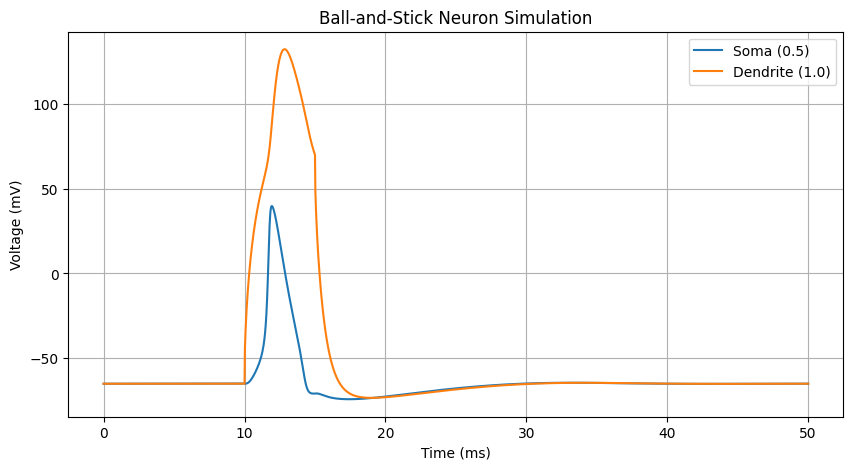

In [ ]:
from neuron import h
import matplotlib.pyplot as plt
import numpy as np

# 1. Create sections
soma = h.Section(name="soma")
dend = h.Section(name="dend")

# 2. Connect sections
dend.connect(soma(1)) # Connect dendrite's 0 end to soma's 1 end

# 3. Set properties for soma
soma.L = 20
soma.diam = 20
soma.nseg = 1
soma.insert("hh")
soma.gnabar_hh = 0.12
soma.gkbar_hh = 0.036
soma.gl_hh = 0.0003
soma.el_hh = -54.3

# 4. Set properties for dendrite
dend.L = 200
dend.diam = 1
dend.nseg = 5 # More segments for the dendrite to capture cable properties
dend.insert("pas")
dend.g_pas = 0.00003
dend.e_pas = -65
dend.Ra = 100 # Axial resistance

# 5. Add a stimulus to the dendrite
stim = h.IClamp(dend(1)) # Stimulate the far end of the dendrite
stim.delay = 10
stim.dur = 5
stim.amp = 0.5

# 6. Record data
rec_t = h.Vector()
rec_t.record(h._ref_t)
rec_v_soma = h.Vector()
rec_v_soma.record(soma(0.5)._ref_v)
rec_v_dend = h.Vector()
rec_v_dend.record(dend(1)._ref_v)

# 7. Run simulation
h.finitialize(-65)
h.t = 0
h.tstop = 50
h.run()

# 8. Plot results
plt.figure(figsize=(10, 5))
plt.plot(rec_t, rec_v_soma, label="Soma (0.5)")
plt.plot(rec_t, rec_v_dend, label="Dendrite (1.0)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Ball-and-Stick Neuron Simulation")
plt.legend()
plt.grid(True)
plt.show()

Running simulations...
Simulations complete.

Maximal effektiver Zeitpunkt (t*_S2): 5.50 ms
Maximale Peakspannung (V*_peak) bei t*_S2: -58.5875 mV


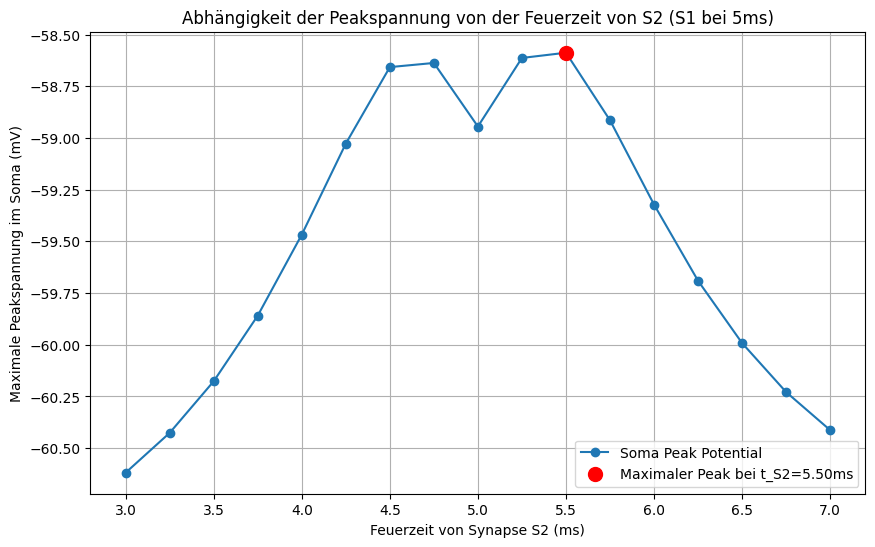

Gewünschtes Feuerfenster (W) für S2: [5.00 ms, 6.00 ms]
Minimale Peakspannung innerhalb des Fensters (V_peak_min_in_W): -59.3220 mV
Maximale Peakspannung außerhalb des Fensters (V_peak_max_out_W): -58.6370 mV
Fehler: Die Bedingung V_peak_max_out_W < V_peak_min_in_W ist nicht erfüllt.
  V_peak_max_out_W = -58.6370, V_peak_min_in_W = -59.3220
  Kein Schwellenwert kann gefunden werden, der die Bedingung strikt erfüllt. Überprüfen Sie Ihre Daten oder die Feinheit der S2-Zeitschritte.
  Möglicherweise sind die Peakspannungen an den Rändern des Fensters und knapp außerhalb sehr ähnlich.


In [6]:
from neuron import h, gui # gui is optional, but good for development
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Cell Model ---
class Cell:
    def __init__(self):
        self.soma = None
        self.dend0 = None
        self.dend1 = None
        self.dend2 = None
        self.all_sections = []
        self._create_morphology()
        self._set_biophysics()
        self._connect_sections()

    def _create_morphology(self):
        # Soma
        self.soma = h.Section(name='soma', cell=self)
        self.soma.L = 18.8  # um
        self.soma.diam = 18.8  # um
        self.soma.nseg = 1
        self.all_sections.append(self.soma)

        # Dend0 (connects to Soma)
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend0.L = 200  # um
        self.dend0.diam = 2    # um
        self.dend0.nseg = 5
        self.all_sections.append(self.dend0)

        # Dend1 (branches off Dend0, for Synapse S2)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend1.L = 20   # um
        self.dend1.diam = 2    # um
        self.dend1.nseg = 5 # As per "Dend: nseg=5"
        self.all_sections.append(self.dend1)

        # Dend2 (branches off Dend0, for Synapse S1)
        self.dend2 = h.Section(name='dend2', cell=self)
        self.dend2.L = 20   # um
        self.dend2.diam = 2    # um
        self.dend2.nseg = 5 # As per "Dend: nseg=5"
        self.all_sections.append(self.dend2)

    def _set_biophysics(self):
        e_pas_val = -65.0  # mV
        g_pas_val = 1e-3   # S/cm^2 (0.001)
        Ra_val = 123       # Ohm-cm

        for sec in self.all_sections:
            sec.Ra = Ra_val
            sec.cm = 1.0  # uF/cm^2 (default, but good to be explicit)
            sec.insert('pas')
            sec.e_pas = e_pas_val
            sec.g_pas = g_pas_val
            
    def _connect_sections(self):
        # Dend0 connects to the middle of the Soma
        self.dend0.connect(self.soma(0.5), 0)

        self.dend1.connect(self.dend0(1), 0)
        self.dend2.connect(self.dend1(1), 0)

# --- 2. Add Synapses ---
def add_synapses(cell_model):
    synapses = {}
    
    # Synapse S1 on Dend2
    synapses['S1'] = h.AlphaSynapse(cell_model.dend2(0.5))
    synapses['S1'].tau = 0.1  # ms
    synapses['S1'].gmax = 0.02 # uS
    synapses['S1'].e = 0      # mV (excitatory)

    # Synapse S2 on Dend1
    synapses['S2'] = h.AlphaSynapse(cell_model.dend1(0.5))
    synapses['S2'].tau = 0.1  # ms
    synapses['S2'].gmax = 0.02 # uS
    synapses['S2'].e = 0      # mV (excitatory)
    
    return synapses

# --- 3. Simulation Setup and Execution ---
def run_simulation_experiment():
    # Create cell and synapses
    my_cell = Cell()
    syns = add_synapses(my_cell)

    # Simulation parameters
    h.dt = 0.025  # ms
    h.tstop = 30.0 # ms
    e_pas_val = -65.0 # mV for finitialize
    
    s1_onset_time = 5.0  # ms
    s2_onset_times = np.arange(3.0, 7.001, 0.25) # 3, 3.25, ..., 7.0 ms

    peak_soma_voltages = []

    # Recording vectors
    v_soma_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
    t_vec = h.Vector().record(h._ref_t)

    print("Running simulations...")
    for s2_t in s2_onset_times:
        syns['S1'].onset = s1_onset_time
        syns['S2'].onset = s2_t
        
        h.finitialize(e_pas_val)
        h.run() # or h.continuerun(h.tstop)
        
        # Find peak voltage in soma
        peak_v = -float('inf')
        # Start search after S1 fires, or from beginning if preferred
        # For simplicity, searching the whole trace for absolute peak
        for v_val in v_soma_vec.as_numpy():
            if v_val > peak_v:
                peak_v = v_val
        peak_soma_voltages.append(peak_v)
        # print(f"  S2 at {s2_t:.2f} ms, Soma Peak: {peak_v:.4f} mV")

    print("Simulations complete.")
    return s2_onset_times, peak_soma_voltages

# --- 4. Process Results and Determine Threshold ---
def analyze_results(s2_times, peak_voltages):
    if not peak_voltages:
        print("Error: No peak voltage data to analyze.")
        return

    # a) Plot: Maximum peak voltage vs. S2 firing time
    plt.figure(figsize=(10, 6))
    plt.plot(s2_times, peak_voltages, 'o-', label='Soma Peak Potential')
    plt.xlabel('Feuerzeit von Synapse S2 (ms)')
    plt.ylabel('Maximale Peakspannung im Soma (mV)')
    plt.title('Abhängigkeit der Peakspannung von der Feuerzeit von S2 (S1 bei 5ms)')
    plt.grid(True)
    
    # b) Determine t*_S2: When does S2 need to fire for maximum peak potential?
    V_star_peak = -float('inf')
    t_star_S2 = -1
    for i in range(len(peak_voltages)):
        if peak_voltages[i] > V_star_peak:
            V_star_peak = peak_voltages[i]
            t_star_S2 = s2_times[i]
    
    if t_star_S2 != -1:
        print(f"\nMaximal effektiver Zeitpunkt (t*_S2): {t_star_S2:.2f} ms")
        print(f"Maximale Peakspannung (V*_peak) bei t*_S2: {V_star_peak:.4f} mV")
        plt.scatter([t_star_S2], [V_star_peak], color='red', s=100, zorder=5, label=f'Maximaler Peak bei t_S2={t_star_S2:.2f}ms')
    else:
        print("Fehler: Konnte t_star_S2 nicht bestimmen.")
        plt.show()
        return

    plt.legend()
    plt.show()

    # c) Determine activation threshold
    window_half_width = 0.5  # ms
    firing_window_start = t_star_S2 - window_half_width
    firing_window_end = t_star_S2 + window_half_width
    print(f"Gewünschtes Feuerfenster (W) für S2: [{firing_window_start:.2f} ms, {firing_window_end:.2f} ms]")

    V_peak_min_in_W = float('inf')
    voltages_in_window_times = [] # For debugging/verification
    
    for i in range(len(s2_times)):
        if firing_window_start <= s2_times[i] <= firing_window_end:
            voltages_in_window_times.append(s2_times[i])
            if peak_voltages[i] < V_peak_min_in_W:
                V_peak_min_in_W = peak_voltages[i]
    
    if V_peak_min_in_W == float('inf'):
        print(f"Warnung: Keine simulierten t_S2 Zeiten fallen exakt in das Fenster W oder alle Werte sind identisch.")
        print(f"  Simulierte Zeiten im Fensterbereich: {voltages_in_window_times}")
        # This might happen if t_star_S2 is at the edge and steps are coarse.
        # For this problem, with 0.25ms steps, there should be points in the window.
    else:
        print(f"Minimale Peakspannung innerhalb des Fensters (V_peak_min_in_W): {V_peak_min_in_W:.4f} mV")

    V_peak_max_out_W = -float('inf')
    found_outside_point = False
    for i in range(len(s2_times)):
        if not (firing_window_start <= s2_times[i] <= firing_window_end):
            if peak_voltages[i] > V_peak_max_out_W:
                V_peak_max_out_W = peak_voltages[i]
            found_outside_point = True
            
    if not found_outside_point:
        print("Warnung: Alle simulierten t_S2 Zeiten fallen in das Fenster W. V_peak_max_out_W kann nicht bestimmt werden.")
    elif V_peak_max_out_W == -float('inf'): # Should not happen if found_outside_point is True
        print("Warnung: V_peak_max_out_W konnte nicht bestimmt werden (z.B. alle externen Werte sind identisch niedrig).")
    else:
        print(f"Maximale Peakspannung außerhalb des Fensters (V_peak_max_out_W): {V_peak_max_out_W:.4f} mV")

    if V_peak_min_in_W == float('inf') or V_peak_max_out_W == -float('inf') or not found_outside_point:
        print("Fehler: Kann Schwellenwert nicht bestimmen, da V_peak_min_in_W oder V_peak_max_out_W nicht korrekt ermittelt wurde.")
    elif V_peak_min_in_W <= V_peak_max_out_W:
        print(f"Fehler: Die Bedingung V_peak_max_out_W < V_peak_min_in_W ist nicht erfüllt.")
        print(f"  V_peak_max_out_W = {V_peak_max_out_W:.4f}, V_peak_min_in_W = {V_peak_min_in_W:.4f}")
        print("  Kein Schwellenwert kann gefunden werden, der die Bedingung strikt erfüllt. Überprüfen Sie Ihre Daten oder die Feinheit der S2-Zeitschritte.")
        print("  Möglicherweise sind die Peakspannungen an den Rändern des Fensters und knapp außerhalb sehr ähnlich.")
    else:
        # The threshold V_th must satisfy: V_peak_max_out_W < V_th <= V_peak_min_in_W
        V_th_example_lower = V_peak_max_out_W + 1e-4 # Just above max_out
        V_th_example_upper = V_peak_min_in_W
        V_th_example_mid = (V_peak_max_out_W + V_peak_min_in_W) / 2.0
        
        print(f"\nDie Aktivierungsschwelle V_th muss im Bereich ({V_peak_max_out_W:.4f} mV, {V_peak_min_in_W:.4f} mV] liegen.")
        print(f"  Ein möglicher Wert für V_th wäre z.B. {V_th_example_mid:.4f} mV (Mittelwert),")
        print(f"  oder knapp über {V_peak_max_out_W:.4f} mV (z.B. {V_th_example_lower:.4f} mV),")
        print(f"  oder genau {V_th_example_upper:.4f} mV.")

# --- Main Execution ---
if __name__ == '__main__':
    s2_fire_times, soma_peaks = run_simulation_experiment()
    analyze_results(s2_fire_times, soma_peaks)



--- Ergebnisse für Teil (b): Linearitätsprüfung ---

Running simulation for S1 only (S1 at 5.0 ms)...
Running simulation for S2 only (S2 at 5.5 ms)...
Running simulation for Both S1 (at 5.0 ms) and S2 (at 5.5 ms)...


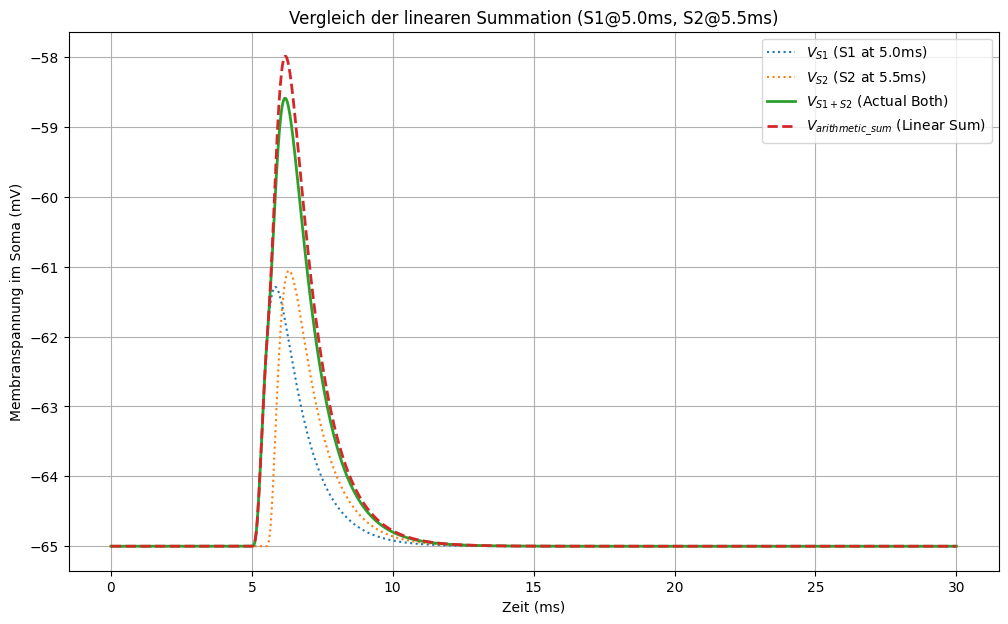


Analyse der Summation um den Peak der gemeinsamen Aktivierung:
  Peak der tatsächlichen gemeinsamen Antwort (V_S1+S2): -58.5875 mV
  Wert der linearen Summe zur gleichen Zeit: -57.9889 mV
Die Spannungsverläufe addieren sich SUBLINEAR.
  Die tatsächliche gemeinsame Antwort ist weniger depolarisiert als die lineare Summe.

Erklärung: Bei exzitatorischen Synapsen in passiven Dendriten ist eine sublineare Summation zu erwarten.
Grund dafür ist, dass die Depolarisation durch eine Synapse die elektrochemische Triebkraft
für andere gleichzeitig oder kurz danach aktive exzitatorische Synapsen reduziert.


In [9]:
from neuron import h, gui # gui is optional
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Cell Model (same as before) ---
class Cell:
    def __init__(self):
        self.soma = None
        self.dend0 = None
        self.dend1 = None
        self.dend2 = None
        self.all_sections = []
        self._create_morphology()
        self._set_biophysics()
        self._connect_sections()

    def _create_morphology(self):
        # Soma
        self.soma = h.Section(name='soma', cell=self)
        self.soma.L = 18.8  # um
        self.soma.diam = 18.8  # um
        self.soma.nseg = 1
        self.all_sections.append(self.soma)

        # Dend0 (connects to Soma)
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend0.L = 200  # um
        self.dend0.diam = 2    # um
        self.dend0.nseg = 5
        self.all_sections.append(self.dend0)

        # Dend1 (branches off Dend0, for Synapse S2)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend1.L = 20   # um
        self.dend1.diam = 2    # um
        self.dend1.nseg = 5 
        self.all_sections.append(self.dend1)

        # Dend2 (branches off Dend0, for Synapse S1)
        self.dend2 = h.Section(name='dend2', cell=self)
        self.dend2.L = 20   # um
        self.dend2.diam = 2    # um
        self.dend2.nseg = 5 
        self.all_sections.append(self.dend2)

    def _set_biophysics(self):
        self.e_pas_val = -65.0  # mV # Made it an attribute for easy access
        g_pas_val = 1e-3   # S/cm^2 (0.001)
        Ra_val = 123       # Ohm-cm

        for sec in self.all_sections:
            sec.Ra = Ra_val
            sec.cm = 1.0  # uF/cm^2 (default, but good to be explicit)
            sec.insert('pas')
            sec.e_pas = self.e_pas_val
            sec.g_pas = g_pas_val
            
    def _connect_sections(self):
        self.dend0.connect(self.soma(0.5), 0)
        self.dend1.connect(self.dend0(1), 0)
        self.dend2.connect(self.dend1(1), 0)

# --- 2. Add Synapses (same as before) ---
def add_synapses(cell_model):
    synapses = {}
    
    synapses['S1'] = h.AlphaSynapse(cell_model.dend2(0.5))
    synapses['S1'].tau = 0.1
    synapses['S1'].gmax = 0.02 # uS (will store this original value)
    synapses['S1'].e = 0    

    synapses['S2'] = h.AlphaSynapse(cell_model.dend1(0.5))
    synapses['S2'].tau = 0.1
    synapses['S2'].gmax = 0.02 # uS (will store this original value)
    synapses['S2'].e = 0      
    
    return synapses

# --- Function for Part (a) - (from previous response, can be kept separate) ---
def run_part_a_experiment():
    # (Code from the previous response for part (a) would go here)
    # For brevity, it's omitted here but assumed to exist if you run both parts.
    # This function would call create_cell, add_synapses, loop S2 times, plot, and analyze for threshold.
    print("Part (a) experiment function would run here.")
    pass


# --- 3. Simulation for Part (b) - Linearity Check ---
def run_linearity_check(s1_fire_time, s2_fire_time):
    my_cell = Cell()
    syns = add_synapses(my_cell)

    # Store original gmax values
    original_gmax_s1 = syns['S1'].gmax
    original_gmax_s2 = syns['S2'].gmax
    
    # Simulation parameters
    h.dt = 0.025
    h.tstop = 30.0 
    v_init = my_cell.e_pas_val # Use e_pas from cell object

    # Recording vectors
    t_vec = h.Vector().record(h._ref_t)
    
    # --- Simulation 1: S1 only ---
    print(f"\nRunning simulation for S1 only (S1 at {s1_fire_time} ms)...")
    syns['S1'].onset = s1_fire_time
    syns['S1'].gmax = original_gmax_s1
    syns['S2'].gmax = 0 # Silence S2
    
    v_soma_s1_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
    h.finitialize(v_init)
    h.run()
    v_soma_s1_trace = np.array(v_soma_s1_vec.as_numpy())

    # --- Simulation 2: S2 only ---
    print(f"Running simulation for S2 only (S2 at {s2_fire_time} ms)...")
    syns['S1'].gmax = 0 # Silence S1
    syns['S2'].onset = s2_fire_time
    syns['S2'].gmax = original_gmax_s2

    v_soma_s2_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
    h.finitialize(v_init)
    h.run()
    v_soma_s2_trace = np.array(v_soma_s2_vec.as_numpy())

    # --- Simulation 3: Both S1 and S2 ---
    print(f"Running simulation for Both S1 (at {s1_fire_time} ms) and S2 (at {s2_fire_time} ms)...")
    syns['S1'].onset = s1_fire_time
    syns['S1'].gmax = original_gmax_s1
    syns['S2'].onset = s2_fire_time
    syns['S2'].gmax = original_gmax_s2

    v_soma_both_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
    h.finitialize(v_init)
    h.run()
    v_soma_both_trace = np.array(v_soma_both_vec.as_numpy())
    
    time_axis = np.array(t_vec.as_numpy())

    # --- 4. Calculate Linear Sum ---
    # V_rest is my_cell.e_pas_val
    delta_v_s1 = v_soma_s1_trace - v_init
    delta_v_s2 = v_soma_s2_trace - v_init
    v_arithmetic_sum_trace = delta_v_s1 + delta_v_s2 + v_init

    # --- 5. Compare and Plot ---
    plt.figure(figsize=(12, 7))
    plt.plot(time_axis, v_soma_s1_trace, label=f'$V_{{S1}}$ (S1 at {s1_fire_time}ms)', linestyle=':')
    plt.plot(time_axis, v_soma_s2_trace, label=f'$V_{{S2}}$ (S2 at {s2_fire_time}ms)', linestyle=':')
    plt.plot(time_axis, v_soma_both_trace, label=f'$V_{{S1+S2}}$ (Actual Both)', linewidth=2)
    plt.plot(time_axis, v_arithmetic_sum_trace, label='$V_{{arithmetic\_sum}}$ (Linear Sum)', linestyle='--', linewidth=2)
    
    plt.xlabel('Zeit (ms)')
    plt.ylabel('Membranspannung im Soma (mV)')
    plt.title(f'Vergleich der linearen Summation (S1@{s1_fire_time}ms, S2@{s2_fire_time}ms)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Conclusion
    # Check the difference at the peak of the 'both' response
    peak_time_index_actual = np.argmax(v_soma_both_trace - v_init) # Index of peak depolarization
    peak_actual = v_soma_both_trace[peak_time_index_actual]
    peak_linear_sum_at_same_time = v_arithmetic_sum_trace[peak_time_index_actual]

    print(f"\nAnalyse der Summation um den Peak der gemeinsamen Aktivierung:")
    print(f"  Peak der tatsächlichen gemeinsamen Antwort (V_S1+S2): {peak_actual:.4f} mV")
    print(f"  Wert der linearen Summe zur gleichen Zeit: {peak_linear_sum_at_same_time:.4f} mV")

    if np.allclose(v_soma_both_trace, v_arithmetic_sum_trace, atol=1e-3): # Check with a small tolerance
        print("Die Spannungsverläufe addieren sich annähernd linear.")
    elif peak_actual < peak_linear_sum_at_same_time:
        print("Die Spannungsverläufe addieren sich SUBLINEAR.")
        print("  Die tatsächliche gemeinsame Antwort ist weniger depolarisiert als die lineare Summe.")
    else: # peak_actual > peak_linear_sum_at_same_time
        print("Die Spannungsverläufe addieren sich SUPERLINEAR.")
        print("  Die tatsächliche gemeinsame Antwort ist stärker depolarisiert als die lineare Summe (ungewöhnlich für passive Dendriten).")
    print("\nErklärung: Bei exzitatorischen Synapsen in passiven Dendriten ist eine sublineare Summation zu erwarten.")
    print("Grund dafür ist, dass die Depolarisation durch eine Synapse die elektrochemische Triebkraft")
    print("für andere gleichzeitig oder kurz danach aktive exzitatorische Synapsen reduziert.")


# --- Main Execution ---
if __name__ == '__main__':
    # --- Call function for Part (a) if needed ---
    # print("--- Ergebnisse für Teil (a) ---")
    # run_part_a_experiment() # This would be the function from the previous response

    # --- Call function for Part (b) ---
    print("\n\n--- Ergebnisse für Teil (b): Linearitätsprüfung ---")
    # Choose specific firing times for S1 and S2 from part (a) results
    # For example, S1 at 5.0 ms and S2 at 5.5 ms (which was optimal in previous example plot)
    s1_t = 5.0
    s2_t = 5.5 
    # You could also try s2_t = 5.0 to see the "dip" case.
    
    run_linearity_check(s1_fire_time=s1_t, s2_fire_time=s2_t)



--- Running for Arrangement 2 (Part c Model) ---

Running Part (a) simulations for Arrangement 2...
Simulations complete.
Results for Arrangement 2 (Part a):
  Maximal effektiver Zeitpunkt (t*_S2): 5.00 ms
  Maximale Peakspannung (V*_peak) bei t*_S2: -59.1063 mV


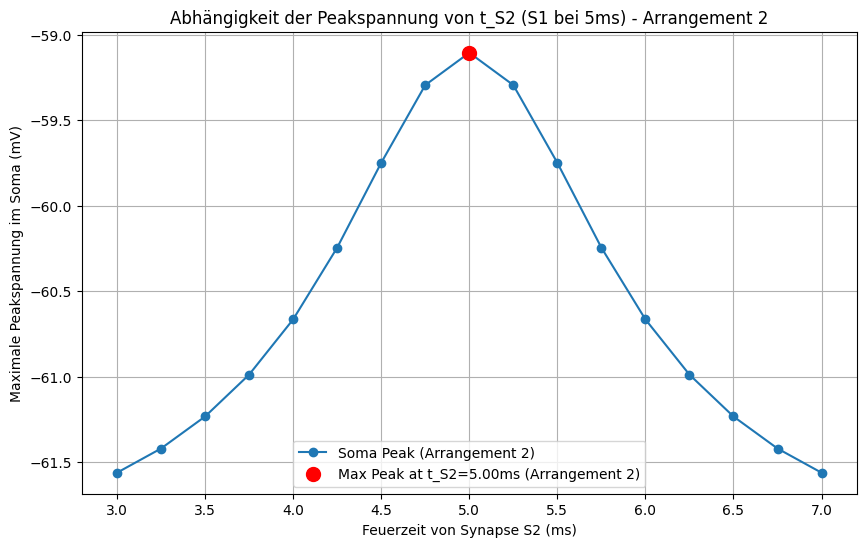

  Für Arrangement 2 - Aktivierungsschwelle:
    Aktivierungsschwelle V_th muss im Bereich (-60.2455 mV, -59.7497 mV] liegen.

Running Part (b) simulations for Arrangement 2 (S1@5.0ms, S2@5.0ms)...


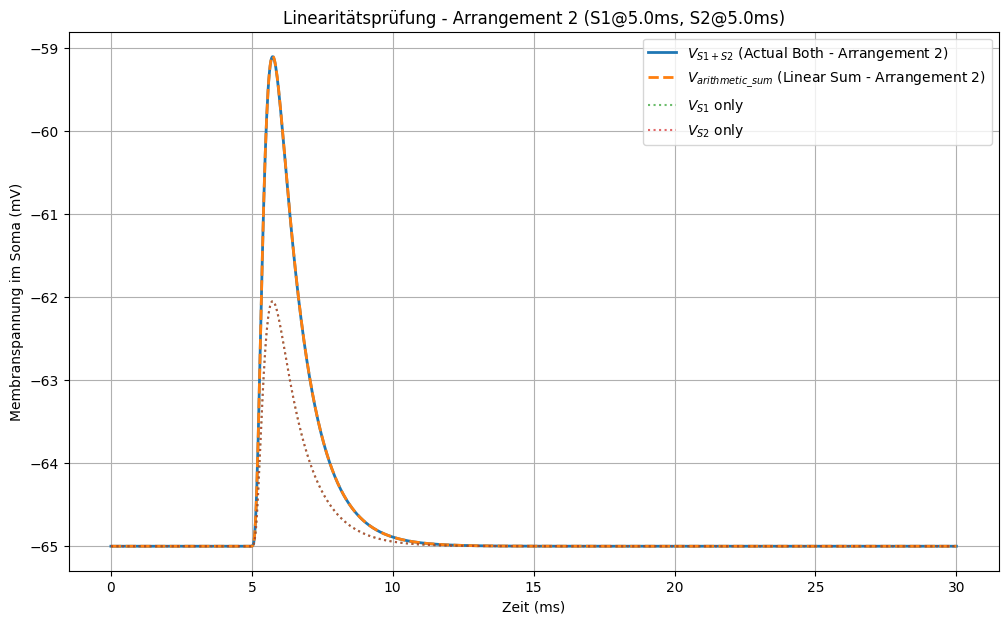

  Linearity for Arrangement 2: Actual peak -59.1063 mV vs Linear sum at same time -59.1004 mV
  Summation is SUBLINEAR.

All simulations for part (c) complete. Review plots.


In [10]:
from neuron import h, gui # gui is optional
import numpy as np
import matplotlib.pyplot as plt

# --- Base Cell Class for Biophysics (Helper) ---
class BaseCellSetup:
    def __init__(self):
        self.soma = None
        self.all_sections = []
        self.e_pas_val = -65.0  # mV
        self.g_pas_val = 1e-3   # S/cm^2
        self.Ra_val = 123       # Ohm-cm
        self.syn_gmax = 0.02    # uS
        self.syn_tau = 0.1      # ms

    def _set_common_biophysics(self, sections_list):
        for sec in sections_list:
            sec.Ra = self.Ra_val
            sec.cm = 1.0
            sec.insert('pas')
            sec.e_pas = self.e_pas_val
            sec.g_pas = self.g_pas_val
            self.all_sections.append(sec) # Keep track for potential iteration

# --- Cell Arrangement 1 (from parts a & b) ---
class CellArrangement1(BaseCellSetup):
    def __init__(self):
        super().__init__()
        self.dend0 = None
        self.dend1 = None # S2 here
        self.dend2 = None # S1 here
        self._create_morphology()
        self._set_common_biophysics([self.soma, self.dend0, self.dend1, self.dend2])
        self._connect_sections()

    def _create_morphology(self):
        self.soma = h.Section(name='soma_arr1', cell=self)
        self.soma.L, self.soma.diam, self.soma.nseg = 18.8, 18.8, 1
        
        self.dend0 = h.Section(name='dend0_arr1', cell=self)
        self.dend0.L, self.dend0.diam, self.dend0.nseg = 200, 2, 5
        
        self.dend1 = h.Section(name='dend1_arr1', cell=self) # For S2
        self.dend1.L, self.dend1.diam, self.dend1.nseg = 20, 2, 5 
        
        self.dend2 = h.Section(name='dend2_arr1', cell=self) # For S1
        self.dend2.L, self.dend2.diam, self.dend2.nseg = 20, 2, 5

    def _connect_sections(self):
        self.dend0.connect(self.soma(0.5), 0)
        self.dend1.connect(self.dend0(1), 0) # S2 on dend1
        self.dend2.connect(self.dend1(1), 0) # S1 on dend2
        
    def add_synapses(self):
        synapses = {}
        synapses['S1'] = h.AlphaSynapse(self.dend2(0.5)) # S1 on Dend2
        synapses['S2'] = h.AlphaSynapse(self.dend1(0.5)) # S2 on Dend1
        for syn_obj in synapses.values():
            syn_obj.tau = self.syn_tau
            syn_obj.gmax = self.syn_gmax
            syn_obj.e = 0
        return synapses

# --- Cell Arrangement 2 (for part c) ---
class CellArrangement2(BaseCellSetup):
    def __init__(self):
        super().__init__()
        self.dend3 = None # Path for S1
        self.dend4 = None # S1 here
        self.dend5 = None # Path for S2
        self.dend6 = None # S2 here
        self._create_morphology()
        self._set_common_biophysics([self.soma, self.dend3, self.dend4, self.dend5, self.dend6])
        self._connect_sections()

    def _create_morphology(self):
        self.soma = h.Section(name='soma_arr2', cell=self)
        self.soma.L, self.soma.diam, self.soma.nseg = 18.8, 18.8, 1

        # Branch for S1: Dend4 -> Dend3 -> Soma
        self.dend3 = h.Section(name='dend3_arr2', cell=self) # Proximal to soma
        self.dend3.L, self.dend3.diam, self.dend3.nseg = 200, 2, 5
        self.dend4 = h.Section(name='dend4_arr2', cell=self) # Distal, S1 here
        self.dend4.L, self.dend4.diam, self.dend4.nseg = 20, 2, 5
        
        # Branch for S2: Dend6 -> Dend5 -> Soma
        self.dend5 = h.Section(name='dend5_arr2', cell=self) # Proximal to soma
        self.dend5.L, self.dend5.diam, self.dend5.nseg = 200, 2, 5
        self.dend6 = h.Section(name='dend6_arr2', cell=self) # Distal, S2 here
        self.dend6.L, self.dend6.diam, self.dend6.nseg = 20, 2, 5

    def _connect_sections(self):
        # Connect Dend3 branch (S1 path) to one side of soma, e.g., soma(0)
        self.dend3.connect(self.soma(0), 0) 
        self.dend4.connect(self.dend3(1), 0) # Dend4 is distal to Dend3

        # Connect Dend5 branch (S2 path) to other side of soma, e.g., soma(1)
        self.dend5.connect(self.soma(1), 0)
        self.dend6.connect(self.dend5(1), 0) # Dend6 is distal to Dend5

    def add_synapses(self):
        synapses = {}
        synapses['S1'] = h.AlphaSynapse(self.dend4(0.5)) # S1 on Dend4 (middle)
        synapses['S2'] = h.AlphaSynapse(self.dend6(0.5)) # S2 on Dend6 (middle)
        for syn_obj in synapses.values():
            syn_obj.tau = self.syn_tau
            syn_obj.gmax = self.syn_gmax
            syn_obj.e = 0
        return synapses

# --- Generic Part (a) Experiment Function ---
def run_part_a_generic(cell_class, arrangement_name="Arrangement"):
    my_cell = cell_class()
    syns = my_cell.add_synapses()

    h.dt, h.tstop = 0.025, 30.0
    v_init = my_cell.e_pas_val
    s1_onset_time = 5.0
    s2_onset_times = np.arange(3.0, 7.001, 0.25)
    peak_soma_voltages = []

    v_soma_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
    # t_vec = h.Vector().record(h._ref_t) # Recorded once if needed outside loop

    print(f"\nRunning Part (a) simulations for {arrangement_name}...")
    for s2_t in s2_onset_times:
        syns['S1'].onset = s1_onset_time
        syns['S2'].onset = s2_t
        h.finitialize(v_init)
        h.run()
        peak_v = np.max(v_soma_vec.as_numpy()) if v_soma_vec.size() > 0 else v_init
        peak_soma_voltages.append(peak_v)
    print("Simulations complete.")

    plt.figure(figsize=(10, 6))
    plt.plot(s2_onset_times, peak_soma_voltages, 'o-', label=f'Soma Peak ({arrangement_name})')
    
    V_star_peak = -float('inf')
    t_star_S2 = -1
    if peak_soma_voltages:
        max_idx = np.argmax(peak_soma_voltages)
        V_star_peak = peak_soma_voltages[max_idx]
        t_star_S2 = s2_onset_times[max_idx]
        plt.scatter([t_star_S2], [V_star_peak], color='red', s=100, zorder=5, 
                    label=f'Max Peak at t_S2={t_star_S2:.2f}ms ({arrangement_name})')
        print(f"Results for {arrangement_name} (Part a):")
        print(f"  Maximal effektiver Zeitpunkt (t*_S2): {t_star_S2:.2f} ms")
        print(f"  Maximale Peakspannung (V*_peak) bei t*_S2: {V_star_peak:.4f} mV")

    plt.xlabel('Feuerzeit von Synapse S2 (ms)')
    plt.ylabel('Maximale Peakspannung im Soma (mV)')
    plt.title(f'Abhängigkeit der Peakspannung von t_S2 (S1 bei 5ms) - {arrangement_name}')
    plt.legend()
    plt.grid(True)
    plt.show(block=False) # Use block=False to show multiple plots

    # Threshold determination logic (copied and adapted from previous)
    if t_star_S2 != -1:
        window_half_width = 0.5
        firing_window_start = t_star_S2 - window_half_width
        firing_window_end = t_star_S2 + window_half_width
        
        V_peak_min_in_W = float('inf')
        for i in range(len(s2_onset_times)):
            if firing_window_start <= s2_onset_times[i] <= firing_window_end:
                if peak_soma_voltages[i] < V_peak_min_in_W:
                    V_peak_min_in_W = peak_soma_voltages[i]
        
        V_peak_max_out_W = -float('inf')
        found_outside = False
        for i in range(len(s2_onset_times)):
            if not (firing_window_start <= s2_onset_times[i] <= firing_window_end):
                if peak_soma_voltages[i] > V_peak_max_out_W:
                    V_peak_max_out_W = peak_soma_voltages[i]
                found_outside = True
        if not found_outside : V_peak_max_out_W = v_init # handle case where all points are in window

        print(f"  Für {arrangement_name} - Aktivierungsschwelle:")
        if V_peak_min_in_W == float('inf') or V_peak_max_out_W == -float('inf') or not found_outside :
             print("    Kann Schwellenwert nicht robust bestimmen (Fensterproblematik).")
        elif V_peak_min_in_W <= V_peak_max_out_W:
            print(f"    Bedingung V_peak_max_out_W < V_peak_min_in_W nicht erfüllt. ({V_peak_max_out_W:.4f} vs {V_peak_min_in_W:.4f})")
        else:
            print(f"    Aktivierungsschwelle V_th muss im Bereich ({V_peak_max_out_W:.4f} mV, {V_peak_min_in_W:.4f} mV] liegen.")
    return s2_onset_times, peak_soma_voltages, t_star_S2


# --- Generic Part (b) Experiment Function ---
def run_part_b_generic(cell_class, s1_fire_time, s2_fire_time, arrangement_name="Arrangement"):
    my_cell = cell_class()
    syns = my_cell.add_synapses()
    original_gmax_s1 = syns['S1'].gmax
    original_gmax_s2 = syns['S2'].gmax
    
    h.dt, h.tstop = 0.025, 30.0
    v_init = my_cell.e_pas_val
    t_vec = h.Vector().record(h._ref_t)

    def simulate_scenario(s1_active, s2_active, s1_t, s2_t):
        syns['S1'].gmax = original_gmax_s1 if s1_active else 0
        syns['S1'].onset = s1_t if s1_active else 0 # onset time irrelevant if gmax=0
        syns['S2'].gmax = original_gmax_s2 if s2_active else 0
        syns['S2'].onset = s2_t if s2_active else 0
        
        v_vec = h.Vector().record(my_cell.soma(0.5)._ref_v)
        h.finitialize(v_init)
        h.run()
        return np.array(v_vec.as_numpy())

    print(f"\nRunning Part (b) simulations for {arrangement_name} (S1@{s1_fire_time}ms, S2@{s2_fire_time}ms)...")
    v_soma_s1_trace = simulate_scenario(True, False, s1_fire_time, s2_fire_time)
    v_soma_s2_trace = simulate_scenario(False, True, s1_fire_time, s2_fire_time)
    v_soma_both_trace = simulate_scenario(True, True, s1_fire_time, s2_fire_time)
    time_axis = np.array(t_vec.as_numpy()) # Get time axis after one run

    delta_v_s1 = v_soma_s1_trace - v_init
    delta_v_s2 = v_soma_s2_trace - v_init
    v_arithmetic_sum_trace = delta_v_s1 + delta_v_s2 + v_init

    plt.figure(figsize=(12, 7))
    plt.plot(time_axis, v_soma_both_trace, label=f'$V_{{S1+S2}}$ (Actual Both - {arrangement_name})', linewidth=2)
    plt.plot(time_axis, v_arithmetic_sum_trace, label=f'$V_{{arithmetic\_sum}}$ (Linear Sum - {arrangement_name})', linestyle='--', linewidth=2)
    plt.plot(time_axis, v_soma_s1_trace, label=f'$V_{{S1}}$ only', linestyle=':', alpha=0.7)
    plt.plot(time_axis, v_soma_s2_trace, label=f'$V_{{S2}}$ only', linestyle=':', alpha=0.7)
    
    plt.xlabel('Zeit (ms)')
    plt.ylabel('Membranspannung im Soma (mV)')
    plt.title(f'Linearitätsprüfung - {arrangement_name} (S1@{s1_fire_time}ms, S2@{s2_fire_time}ms)')
    plt.legend()
    plt.grid(True)
    plt.show(block=False)

    peak_idx_actual = np.argmax(v_soma_both_trace - v_init)
    peak_actual = v_soma_both_trace[peak_idx_actual]
    peak_linear = v_arithmetic_sum_trace[peak_idx_actual]
    print(f"  Linearity for {arrangement_name}: Actual peak {peak_actual:.4f} mV vs Linear sum at same time {peak_linear:.4f} mV")
    if peak_actual < peak_linear - 1e-4 : # Add tolerance for sublinearity check
         print("  Summation is SUBLINEAR.")
    elif peak_actual > peak_linear + 1e-4:
         print("  Summation is SUPERLINEAR.")
    else:
         print("  Summation is (approximately) LINEAR.")


# --- Main Execution for Part (c) ---
if __name__ == '__main__':
    # For reference, you might want to run Arrangement 1 first if you haven't stored its plot
    # print("--- Running for Arrangement 1 (Original Model) ---")
    # _, _, t_star_s2_arr1 = run_part_a_generic(CellArrangement1, "Arrangement 1")
    # if t_star_s2_arr1 != -1: # Check if t_star_S2 was found
    #    run_part_b_generic(CellArrangement1, s1_fire_time=5.0, s2_fire_time=t_star_s2_arr1, arrangement_name="Arrangement 1")
    # else:
    #    run_part_b_generic(CellArrangement1, s1_fire_time=5.0, s2_fire_time=5.5, arrangement_name="Arrangement 1") # Fallback

    print("\n\n--- Running for Arrangement 2 (Part c Model) ---")
    s2_times_arr2, peaks_arr2, t_star_s2_arr2 = run_part_a_generic(CellArrangement2, "Arrangement 2")
    if t_star_s2_arr2 != -1: # Check if t_star_S2 was found
        run_part_b_generic(CellArrangement2, s1_fire_time=5.0, s2_fire_time=t_star_s2_arr2, arrangement_name="Arrangement 2")
    else:
        # Fallback if t_star_s2 cannot be determined (e.g. all peaks are the same)
        run_part_b_generic(CellArrangement2, s1_fire_time=5.0, s2_fire_time=5.5, arrangement_name="Arrangement 2") # Fallback S2 time

    # Allow plots to be displayed before program exits if run in non-interactive mode
    print("\nAll simulations for part (c) complete. Review plots.")
    plt.show() # Final show to keep all plots open until closed by user